In [2]:
import geopandas as gpd
import pandas as pd 
import glob
import os

county_ward = pd.read_pickle('county_ward_list.pkl')

wards_gdf = gpd.read_file("data/Kenya_wards_NDMA.shp")
wards_gdf.set_crs(epsg=4326, inplace=True) 
wards_gdf = wards_gdf.merge(
    county_ward, left_on="Ward", right_on="Ward", how="left")

wards_gdf.dropna(subset=['County'], inplace=True)

counties_gdf = gpd.read_file("data/ken_admbnda_adm1_iebc_20191031.shp")

wards_gdf.to_file("data/Kenya_wards_with_counties.geojson", driver="GeoJSON")


import os, glob
import pandas as pd

base_dir = "/home/ebenezer/Desktop/NDMADEWS_ML_DS/dews-flask-application/early_warning_dashboard-main/data"

def load_latest_prediction_file(horizon: int, target: str):
    """
    Load latest prediction file for a given horizon and target variable.

    Parameters
    ----------
    horizon : int
        Prediction horizon in months (1, 2, or 3).
    target : str
        One of {"wasting_smoothed", "wasting_risk_smoothed"}.

    Returns
    -------
    pd.DataFrame
        DataFrame with standardized columns:
        - For horizon==1:
            * observed column: 'observed' (wasting) or 'risk_observed' (risk)
        - For all horizons:
            * predictions: 'pred_{h}mo' or 'risk_pred_{h}mo'
            * CIs: 'lower_bound_{h}mo'/'upper_bound_{h}mo' or risk_*
    """
    assert target in {"wasting_smoothed", "wasting_risk_smoothed"}
    pattern = os.path.join(base_dir, f"{target}_pred_hb_{horizon}_36m_*.csv")
    matching_files = glob.glob(pattern)

    if not matching_files:
        raise FileNotFoundError(f"No matching files found for horizon {horizon} and target '{target}' in {base_dir}")

    matching_files.sort()  # filenames encode chronology
    latest_file = matching_files[-1]
    print(f"[{target}] horizon {horizon}: {latest_file}")

    df = pd.read_csv(latest_file)
    df["time_period"] = pd.to_datetime(df["time_period"])
    df["Ward"] = df["Ward"].astype(str).str.strip()

    col_suffix = f"{horizon}mo"
    is_risk = (target == "wasting_risk_smoothed")
    prefix = "risk_" if is_risk else ""

    # Build rename map
    rename_map = {
        "yhat": f"{prefix}pred_{col_suffix}",
        "lower_bound": f"{prefix}lower_bound_{col_suffix}",
        "upper_bound": f"{prefix}upper_bound_{col_suffix}",
    }
    # Only the 1-month files contain the contemporaneous observed value needed downstream
    if horizon == 1:
        rename_map[target] = f"{prefix}observed"

    df = df.rename(columns=rename_map)
    return df

# --- Load wasting_smoothed  ---
df_1mo = load_latest_prediction_file(1, "wasting_smoothed")
df_2mo = load_latest_prediction_file(2, "wasting_smoothed")
df_3mo = load_latest_prediction_file(3, "wasting_smoothed")

# --- Load wasting_risk_smoothed  ---
risk_1mo = load_latest_prediction_file(1, "wasting_risk_smoothed")
risk_2mo = load_latest_prediction_file(2, "wasting_risk_smoothed")
risk_3mo = load_latest_prediction_file(3, "wasting_risk_smoothed")

# Merge county info (assumes a DataFrame `county_ward` with ['Ward','County'])
df_1mo = df_1mo.merge(county_ward[['Ward', 'County']], on='Ward', how='left')
df_2mo = df_2mo.merge(county_ward[['Ward', 'County']], on='Ward', how='left')
df_3mo = df_3mo.merge(county_ward[['Ward', 'County']], on='Ward', how='left')

risk_1mo = risk_1mo.merge(county_ward[['Ward', 'County']], on='Ward', how='left')
risk_2mo = risk_2mo.merge(county_ward[['Ward', 'County']], on='Ward', how='left')
risk_3mo = risk_3mo.merge(county_ward[['Ward', 'County']], on='Ward', how='left')

# Write outputs 
df_1mo.to_csv("data/Smoothed_wasting_prediction_hb_1.csv", index=False)
df_2mo.to_csv("data/Smoothed_wasting_prediction_hb_2.csv", index=False)
df_3mo.to_csv("data/Smoothed_wasting_prediction_hb_3.csv", index=False)

risk_1mo.to_csv("data/Smoothed_wasting_risk_prediction_hb_1.csv", index=False)
risk_2mo.to_csv("data/Smoothed_wasting_risk_prediction_hb_2.csv", index=False)
risk_3mo.to_csv("data/Smoothed_wasting_risk_prediction_hb_3.csv", index=False)

[wasting_smoothed] horizon 1: /home/ebenezer/Desktop/NDMADEWS_ML_DS/dews-flask-application/early_warning_dashboard-main/data/wasting_smoothed_pred_hb_1_36m_2021_5_to_2025_8.csv
[wasting_smoothed] horizon 2: /home/ebenezer/Desktop/NDMADEWS_ML_DS/dews-flask-application/early_warning_dashboard-main/data/wasting_smoothed_pred_hb_2_36m_2021_6_to_2025_9.csv
[wasting_smoothed] horizon 3: /home/ebenezer/Desktop/NDMADEWS_ML_DS/dews-flask-application/early_warning_dashboard-main/data/wasting_smoothed_pred_hb_3_36m_2021_7_to_2025_10.csv
[wasting_risk_smoothed] horizon 1: /home/ebenezer/Desktop/NDMADEWS_ML_DS/dews-flask-application/early_warning_dashboard-main/data/wasting_risk_smoothed_pred_hb_1_36m_2021_5_to_2025_8.csv
[wasting_risk_smoothed] horizon 2: /home/ebenezer/Desktop/NDMADEWS_ML_DS/dews-flask-application/early_warning_dashboard-main/data/wasting_risk_smoothed_pred_hb_2_36m_2021_6_to_2025_9.csv
[wasting_risk_smoothed] horizon 3: /home/ebenezer/Desktop/NDMADEWS_ML_DS/dews-flask-applicatio

✅ Saved Wasting Prevalence trend (long) with CI: data/clean_trend_long_with_CI.csv


/tmp/ipykernel_14709/2380081492.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(wards))


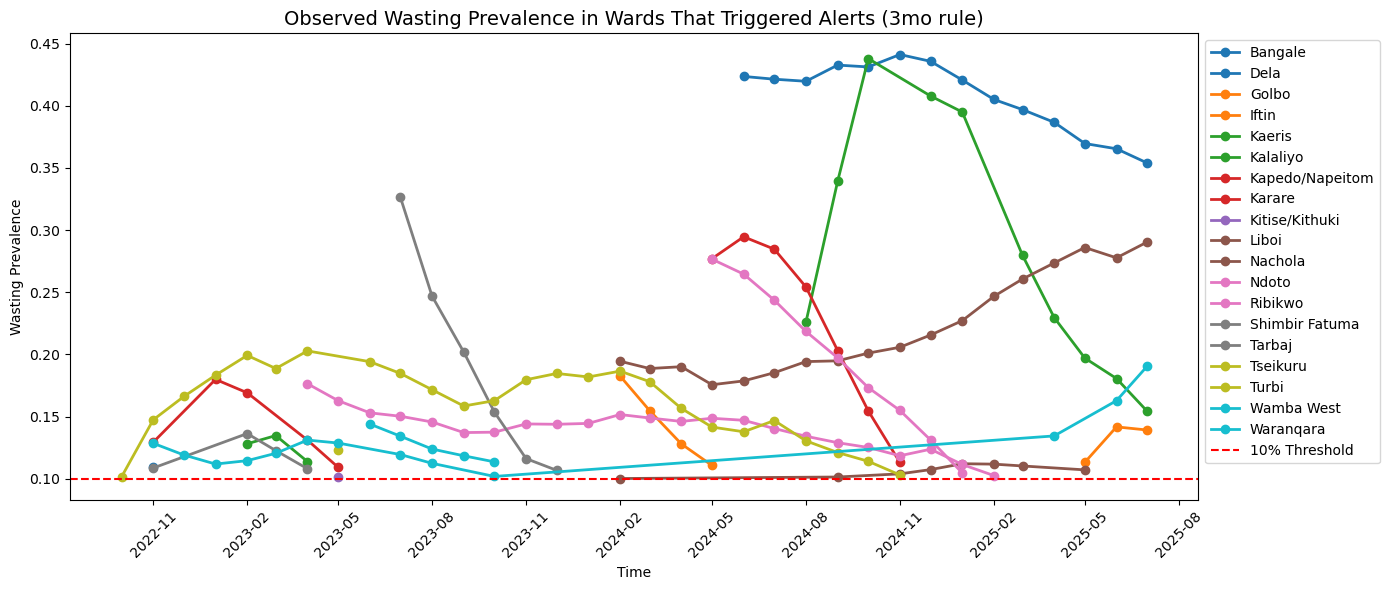

✅ Saved Wasting Prevalence trend (wide) with CI: data/clean_trend_wide_with_CI.csv
✅ Saved Wasting Risk trend (long) with CI: data/clean_trend_long_with_CI_risk.csv


/tmp/ipykernel_14709/2380081492.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(wards))
/tmp/ipykernel_14709/2380081492.py:177: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


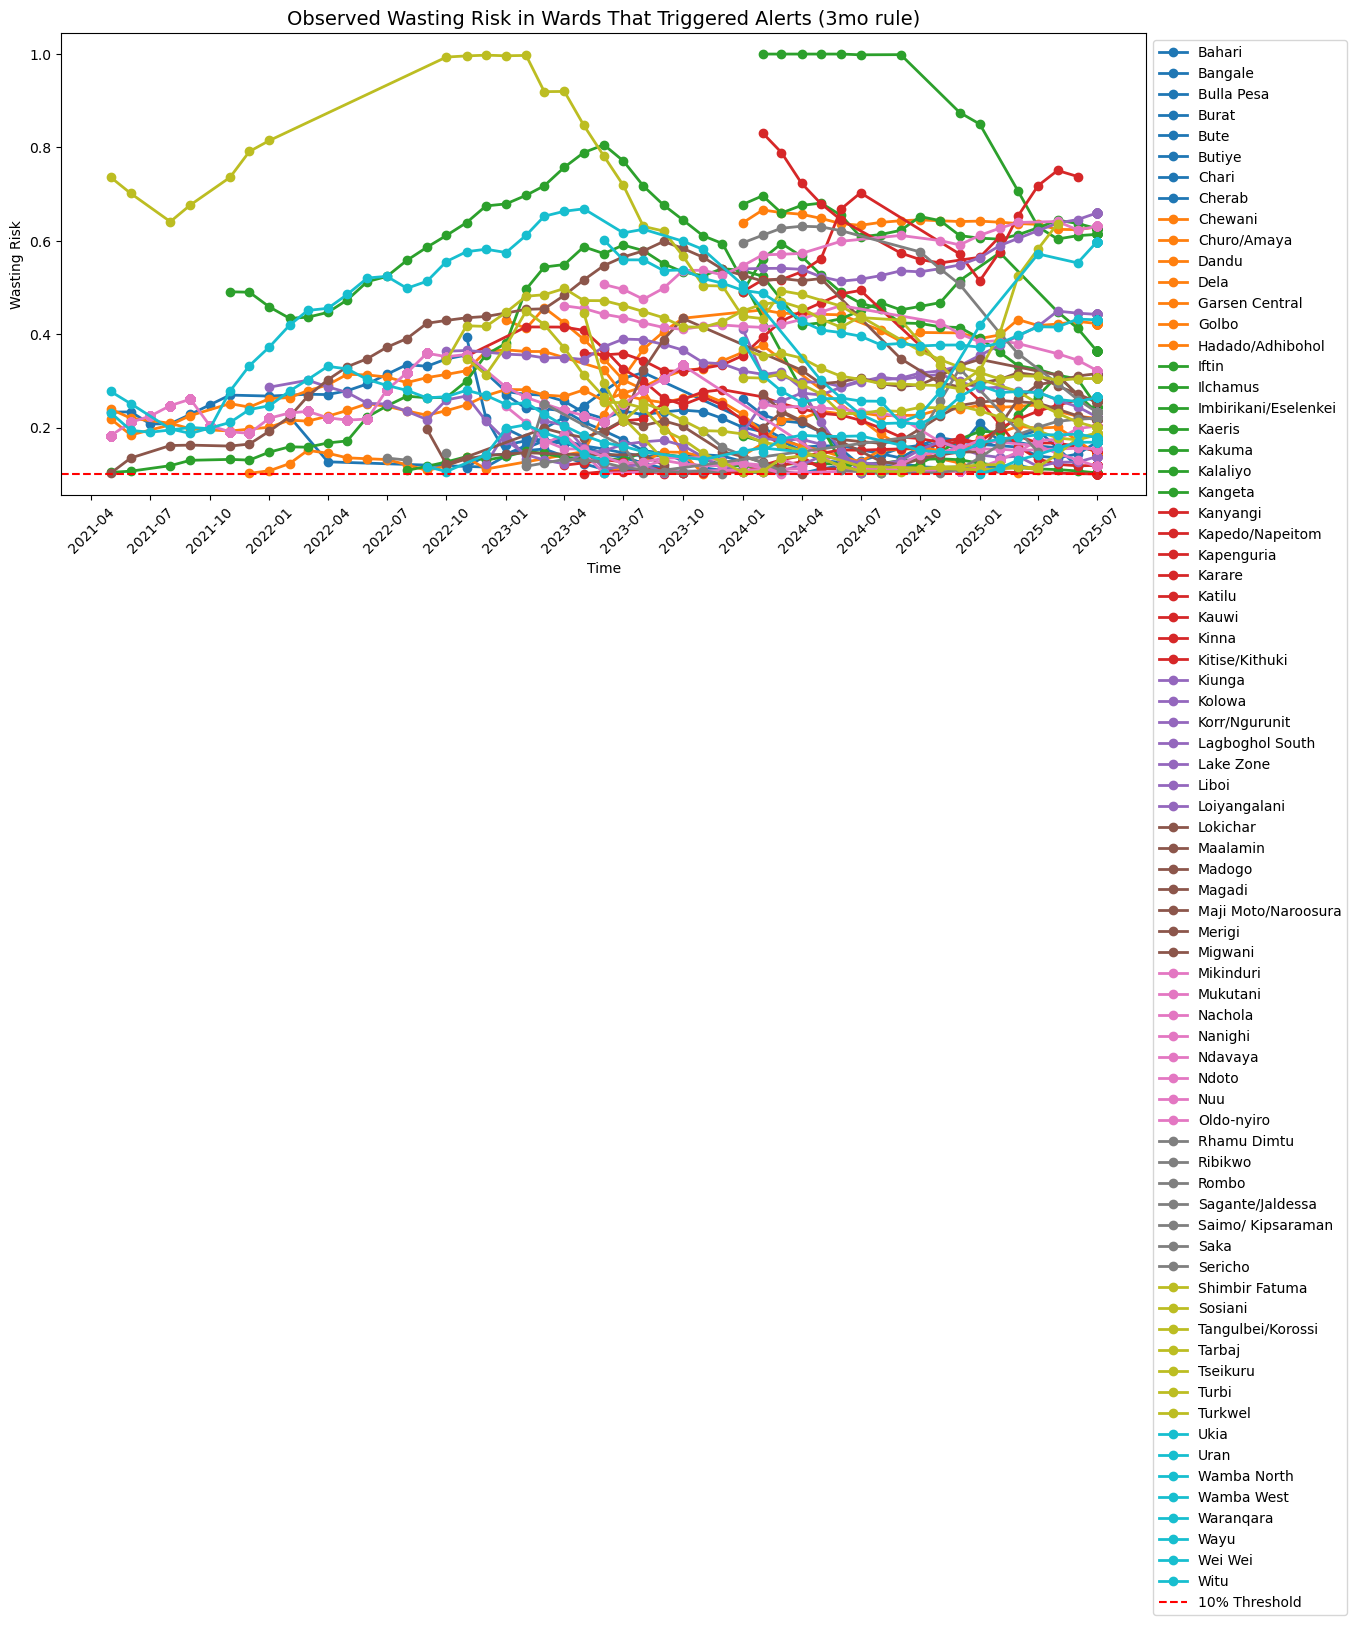

✅ Saved Wasting Risk trend (wide) with CI: data/clean_trend_wide_with_CI_risk.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =============================
# Tunables
# =============================
EPS = 0.01                 # deadband for trend classification (1 percentage point)
ALERT_THRESHOLD = 0.10     # 10% alert threshold
EMERGENCY_THRESHOLD = 0.15 # 15% emergency threshold (optional override; see logic)
PLOT_ALERTS = True         # set False if you don’t want figures

# =============================
# Classifiers
# =============================
def classify(delta: float, eps: float = EPS) -> str:
    if pd.isna(delta):
        return "No Data"
    if delta > eps:
        return "Increasing"
    if delta < -eps:
        return "Decreasing"
    return "Stable"

def classify_with_ci(observed, lower, upper, eps: float = EPS) -> str:
    if pd.isna(observed) or pd.isna(lower) or pd.isna(upper):
        return "No Data"
    if lower > observed + eps:
        return "Increasing"
    if upper < observed - eps:
        return "Decreasing"
    return "Stable"

# =============================
# Core pipeline (runs once per target)
# =============================
def run_trend_pipeline_for_target(
    target_name: str,
    file_stub: str,
    col_prefix: str = ""
):
    """
    Inputs (CSV):
      data/Smoothed_{file_stub}_prediction_hb_1.csv
      data/Smoothed_{file_stub}_prediction_hb_2.csv
      data/Smoothed_{file_stub}_prediction_hb_3.csv

    Output CSVs:
      data/clean_trend_long_with_CI{_risk}.csv
      data/clean_trend_wide_with_CI{_risk}.csv
    """

    # === Load data ===
    hb_1 = pd.read_csv(f"data/Smoothed_{file_stub}_prediction_hb_1.csv")
    hb_2 = pd.read_csv(f"data/Smoothed_{file_stub}_prediction_hb_2.csv")
    hb_3 = pd.read_csv(f"data/Smoothed_{file_stub}_prediction_hb_3.csv")

    for df in (hb_1, hb_2, hb_3):
        df["time_period"] = pd.to_datetime(df["time_period"])
        df["Ward"] = df["Ward"].astype(str).str.strip()

    # Column mappings (handle "" vs "risk_" prefixes)
    obs_col  = f"{col_prefix}observed"
    p1_col   = f"{col_prefix}pred_1mo";  lb1_col = f"{col_prefix}lower_bound_1mo";  ub1_col = f"{col_prefix}upper_bound_1mo"
    p2_col   = f"{col_prefix}pred_2mo";  lb2_col = f"{col_prefix}lower_bound_2mo";  ub2_col = f"{col_prefix}upper_bound_2mo"
    p3_col   = f"{col_prefix}pred_3mo";  lb3_col = f"{col_prefix}lower_bound_3mo";  ub3_col = f"{col_prefix}upper_bound_3mo"

    # Normalize column names we actually use
    hb_1 = hb_1.rename(columns={obs_col: "observed", p1_col: "pred_1mo", lb1_col: "lower_bound_1mo", ub1_col: "upper_bound_1mo"})
    hb_2 = hb_2.rename(columns={p2_col: "pred_2mo",   lb2_col: "lower_bound_2mo",   ub2_col: "upper_bound_2mo"})
    hb_3 = hb_3.rename(columns={p3_col: "pred_3mo",   lb3_col: "lower_bound_3mo",   ub3_col: "upper_bound_3mo"})

    # Keep only needed cols
    obs = hb_1[["Ward", "County", "time_period", "observed"]].copy()

    # Shift predictions back so the forecast made at t aligns to its target month t
    def shift_predictions(df, months_back, horizon_label):
        return (
            df.assign(time_period=df["time_period"] - pd.DateOffset(months=months_back))[
                ["Ward", "time_period", f"pred_{horizon_label}", f"lower_bound_{horizon_label}", f"upper_bound_{horizon_label}"]
            ]
        )

    pred_1mo = shift_predictions(hb_1, 1, "1mo")
    pred_2mo = shift_predictions(hb_2, 2, "2mo")
    pred_3mo = shift_predictions(hb_3, 3, "3mo")

    # Merge all horizons
    merged = (
        obs.merge(pred_1mo, on=["Ward", "time_period"], how="left")
           .merge(pred_2mo, on=["Ward", "time_period"], how="left")
           .merge(pred_3mo, on=["Ward", "time_period"], how="left")
           .sort_values(["Ward", "time_period"])
    )

    # Keep rows where we have observed and the 3-month horizon (since alerts depend on 3mo)
    merged = merged.dropna(subset=["observed", "pred_3mo", "lower_bound_3mo", "upper_bound_3mo"])

    # Trends (simple diff vs observed)
    merged["trend_1mo"] = (merged.get("pred_1mo") - merged["observed"]).apply(classify) if "pred_1mo" in merged else "No Data"
    merged["trend_2mo"] = (merged.get("pred_2mo") - merged["observed"]).apply(classify) if "pred_2mo" in merged else "No Data"
    merged["trend_3mo"] = (merged["pred_3mo"] - merged["observed"]).apply(classify)

    # CI-based trends (the ones we actually use for alerts: 3mo)
    merged["trend_with_CI_1mo"] = merged.apply(lambda r: classify_with_ci(r["observed"], r.get("lower_bound_1mo"), r.get("upper_bound_1mo")), axis=1)
    merged["trend_with_CI_2mo"] = merged.apply(lambda r: classify_with_ci(r["observed"], r.get("lower_bound_2mo"), r.get("upper_bound_2mo")), axis=1)
    merged["trend_with_CI_3mo"] = merged.apply(lambda r: classify_with_ci(r["observed"], r["lower_bound_3mo"], r["upper_bound_3mo"]), axis=1)

    # Observed 2-month trend (simple and fast)
    merged["observed_slope_2mo"] = merged.groupby("Ward")["observed"].diff()
    merged["observed_trend_2mo"] = merged["observed_slope_2mo"].apply(classify)

    # -------- Long format (only the columns we use downstream) --------
    def to_long(h_label: str):
        cols = {
            f"trend_{h_label}": "predicted_trend",
            f"pred_{h_label}": "predicted_value",
            f"lower_bound_{h_label}": "lower_bound",
            f"upper_bound_{h_label}": "upper_bound",
            f"trend_with_CI_{h_label}": "predicted_trend_CI",
        }
        keep = ["Ward", "time_period"] + list(cols.keys())
        df = merged[[c for c in keep if c in merged.columns]].rename(columns=cols)
        df["horizon"] = h_label
        return df

    trend_long = pd.concat([to_long("1mo"), to_long("2mo"), to_long("3mo")], ignore_index=True, sort=False)

    # Attach observed & county once
    trend_long = trend_long.merge(
        merged[["Ward", "County", "time_period", "observed", "observed_trend_2mo"]],
        on=["Ward", "time_period"],
        how="left"
    )

    # Alert flag:
    #  - Only on 3mo horizon rows
    #  - observed >= ALERT_THRESHOLD
    #  - CI-based 3mo trend is Stable/Increasing
    #  - observed 2mo trend is Stable/Increasing
    #  - (optional) emergency override: observed >= EMERGENCY_THRESHOLD
    trend_long["alert_flag"] = False
    is_3mo = trend_long["horizon"].eq("3mo")
    ok_obs = trend_long["observed"].ge(ALERT_THRESHOLD)
    ok_ci  = trend_long["predicted_trend_CI"].isin(["Increasing", "Stable"])
    #ok_obs_trend = trend_long["observed_trend_2mo"].isin(["Increasing", "Stable"])

    #trend_long.loc[is_3mo & ok_obs & ok_ci & ok_obs_trend, "alert_flag"] = True
    trend_long.loc[is_3mo & ok_obs & ok_ci, "alert_flag"] = True


    # Sort & save (long)
    trend_long = trend_long.sort_values(["Ward", "time_period", "horizon"])
    long_path = f"data/clean_trend_long_with_CI{'_risk' if col_prefix=='risk_' else ''}.csv"
    trend_long.to_csv(long_path, index=False)
    print(f"✅ Saved {target_name} trend (long) with CI: {long_path}")

    # === Optional quick plots (only alerted rows, any horizon shown with 3mo logic) ===
    if PLOT_ALERTS:
        alerts_3mo = trend_long[(trend_long["horizon"] == "3mo") & (trend_long["alert_flag"])]
        wards = alerts_3mo["Ward"].unique()
        if len(wards) > 0:
            colors = plt.cm.get_cmap("tab10", len(wards))

            # Observed only
            fig, ax = plt.subplots(figsize=(14, 6))
            for i, wname in enumerate(wards):
                w = alerts_3mo[alerts_3mo["Ward"] == wname].sort_values("time_period")
                ax.plot(w["time_period"], w["observed"], label=wname, color=colors(i), marker="o", linewidth=2)
            ax.axhline(ALERT_THRESHOLD, linestyle="--", color="red", linewidth=1.5, label=f"{int(ALERT_THRESHOLD*100)}% Threshold")
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.tick_params(axis='x', rotation=45)
            ax.set_title(f"Observed {target_name} in Wards That Triggered Alerts (3mo rule)", fontsize=14)
            ax.set_ylabel(target_name); ax.set_xlabel("Time")
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout(); plt.show()

    # -------- Wide format (keep it simple & correct) --------
    # 1) Pivot horizon-specific fields
    base = trend_long.sort_values(["Ward", "time_period", "horizon"]).drop_duplicates(["Ward", "time_period", "horizon"])
    pv_value = base.pivot(index=["Ward","time_period"], columns="horizon", values="predicted_value")
    pv_value.columns = [f"predicted_value_{c}" for c in pv_value.columns]

    pv_trend = base.pivot(index=["Ward","time_period"], columns="horizon", values="predicted_trend")
    pv_trend.columns = [f"predicted_trend_{c}" for c in pv_trend.columns]

    pv_trend_ci = base.pivot(index=["Ward","time_period"], columns="horizon", values="predicted_trend_CI")
    pv_trend_ci.columns = [f"predicted_trend_CI_{c}" for c in pv_trend_ci.columns]

    pv_lb = base.pivot(index=["Ward","time_period"], columns="horizon", values="lower_bound")
    pv_lb.columns = [f"lower_bound_{c}" for c in pv_lb.columns]

    pv_ub = base.pivot(index=["Ward","time_period"], columns="horizon", values="upper_bound")
    pv_ub.columns = [f"upper_bound_{c}" for c in pv_ub.columns]

    # 2) Observed / county / observed_trend_2mo (one row per ward-month)
    observed_block = (base[["Ward","County","time_period","observed","observed_trend_2mo"]]
                      .drop_duplicates(["Ward","time_period"])
                      .set_index(["Ward","time_period"]))

    # 3) Alert flag — ensure we carry the 3mo horizon result correctly
    alert_3mo = base[base["horizon"]=="3mo"][["Ward","time_period","alert_flag"]].set_index(["Ward","time_period"])

    # 4) Combine
    trend_wide = (
        pd.concat([observed_block, alert_3mo, pv_value, pv_trend, pv_trend_ci, pv_lb, pv_ub], axis=1)
          .reset_index()
          .sort_values(["Ward","time_period"])
    )

    # 5) Consecutive alert streaks (based on 3mo alert_flag)
    trend_wide["alert_flag"] = trend_wide["alert_flag"].fillna(False).astype(bool)
    trend_wide["consecutive_alerts"] = 0
    for ward, grp in trend_wide.groupby("Ward", sort=False):
        # increasing count within contiguous True blocks
        streak = (grp["alert_flag"].astype(int)
                  .groupby((~grp["alert_flag"]).cumsum()).cumsum())
        trend_wide.loc[grp.index, "consecutive_alerts"] = streak.values

    wide_path = f"data/clean_trend_wide_with_CI{'_risk' if col_prefix=='risk_' else ''}.csv"
    trend_wide.to_csv(wide_path, index=False)
    print(f"✅ Saved {target_name} trend (wide) with CI: {wide_path}")

# =============================
# Run for both targets
# =============================
# 1) Wasting prevalence (no prefix)
run_trend_pipeline_for_target(
    target_name="Wasting Prevalence",
    file_stub="wasting",
    col_prefix=""
)
# 2) Wasting risk (risk_ prefix)
run_trend_pipeline_for_target(
    target_name="Wasting Risk",
    file_stub="wasting_risk",
    col_prefix="risk_"
)



# compress_figures.py
from PIL import Image
from pathlib import Path

src = Path("assets/figures")   # put your images here
src.mkdir(parents=True, exist_ok=True)

for p in list(src.glob("*.png")) + list(src.glob("*.jpg")) + list(src.glob("*.jpeg")):
    out = p.with_suffix(".webp")
    if out.exists() and out.stat().st_mtime >= p.stat().st_mtime:
        continue
    img = Image.open(p).convert("RGB")
    w, h = img.size
    max_w = 1200
    if w > max_w:
        h = int(h * max_w / w)
        img = img.resize((max_w, h), Image.LANCZOS)
    img.save(out, "WEBP", quality=80, method=6)
    print("✓", out.name)

In [4]:
import dash
from dash import dcc, html, Input, Output, State
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from flask import Flask
import glob
import os
from dash import dash_table

# ======================
# Setup
# ======================
server = Flask(__name__)
app = dash.Dash(
    __name__, server=server,
    suppress_callback_exceptions=True,
    assets_folder="assets",
    assets_url_path="/assets",
)
app.title = "Wasting Prediction Dashboard"

# ======================
# Targets (config)
# ======================
TARGETS = {
    "wasting": {
        "pretty": "Wasting Prevalence",
        "file_stub": "wasting",
        "trend_file": "data/clean_trend_wide_with_CI.csv",
        "prefix": "",            # columns: observed, pred_*, lower_*, upper_*
        "obs_col_in_hb3": "wasting_smoothed"
    },
    "wasting_risk": {
        "pretty": "Wasting Risk",
        "file_stub": "wasting_risk",
        "trend_file": "data/clean_trend_wide_with_CI_risk.csv",
        "prefix": "risk_",       # columns: risk_observed, risk_pred_*, risk_lower_*, risk_upper_*
        "obs_col_in_hb3": "risk_observed"  # if your _hb_3 files have this; otherwise map below
    }
}
ALLOWED_COUNTIES = {"Tana river", "Marsabit", "Isiolo"}

# ======================
# Geo data
# ======================
gdf = gpd.read_file("data/Kenya_wards_with_counties.geojson")
gdf["Ward"] = gdf["Ward"].astype(str).str.strip()

# Keep only wards in the allowed counties
if "County" in gdf.columns:
    gdf = gdf[gdf["County"].isin(ALLOWED_COUNTIES)].copy()
else:
    raise ValueError("Expected 'County' column in Kenya_wards_with_counties.geojson")

gdf["geometry_json"] = gdf["geometry"].apply(lambda g: g.__geo_interface__)


counties = gpd.read_file("data/ken_admbnda_adm1_iebc_20191031.shp").to_crs(gdf.crs)

# ======================
# Helpers: load & standardize
# ======================
def _read_hb(h, target_key):
    """
    Read hb_{h} CSV and standardize columns to generic names for plotting:
    observed, pred_{h}mo, lower_bound_{h}mo, upper_bound_{h}mo.
    """
    t = TARGETS[target_key]
    stub = t["file_stub"]
    pref = t["prefix"]
    path = f"data/Smoothed_{stub}_prediction_hb_{h}.csv"

    df = pd.read_csv(path)
    df["Ward"] = df["Ward"].astype(str).str.strip()
    df["time_period"] = pd.to_datetime(df["time_period"], errors="coerce").dt.to_period("M").dt.start_time

    rename = {}
    if h == 1:
        rename.update({
            f"{pref}pred_1mo": "pred_1mo",
            f"{pref}lower_bound_1mo": "lower_bound_1mo",
            f"{pref}upper_bound_1mo": "upper_bound_1mo",
        })
    elif h == 3:
        rename.update({
            f"{pref}pred_3mo": "pred_3mo",
            f"{pref}lower_bound_3mo": "lower_bound_3mo",
            f"{pref}upper_bound_3mo": "upper_bound_3mo",
        })

    # Try to standardize observed -> "observed" from multiple possible raw names
    obs_candidates = [
        TARGETS[target_key]["obs_col_in_hb3"],  # configured per target
        f"{pref}observed",                      # generic pipeline output
        "wasting_smoothed",                     # prevalence raw
        "risk_observed",                        # risk raw (if present)
        "wasting_risk_smoothed",                # some pipelines use this
        "observed"                              # already standardized
    ]
    found = next((c for c in obs_candidates if c in df.columns), None)
    if found:
        rename[found] = "observed"

    df = df.rename(columns=rename)
    return df

def load_all_for_target(target_key):
    hb1 = _read_hb(1, target_key)
    hb3 = _read_hb(3, target_key)

    # --- Filter hb files to allowed counties/wards ---
    allowed_wards = set(gdf["Ward"].unique())

    if "County" in hb1.columns:
        hb1 = hb1[hb1["County"].isin(ALLOWED_COUNTIES)].copy()
    else:
        hb1 = hb1[hb1["Ward"].isin(allowed_wards)].copy()

    if "County" in hb3.columns:
        hb3 = hb3[hb3["County"].isin(ALLOWED_COUNTIES)].copy()
    else:
        hb3 = hb3[hb3["Ward"].isin(allowed_wards)].copy()

    # --- Trend file (already standardized) ---
    trend_file = TARGETS[target_key]["trend_file"]
    trend_df = pd.read_csv(trend_file)
    trend_df["Ward"] = trend_df["Ward"].astype(str).str.strip()
    trend_df["time_period"] = pd.to_datetime(trend_df["time_period"]).dt.to_period("M").dt.start_time

    # Filter trends to allowed counties/wards
    trend_df = trend_df[trend_df["County"].isin(ALLOWED_COUNTIES)].copy()
    trend_df = trend_df[trend_df["Ward"].isin(allowed_wards)].copy()

    # === Ensure hb3 has an 'observed' column ===
    if "observed" not in hb3.columns:
        # merge observed from trend_df (same keyed by Ward + time_period)
        obs = trend_df[["Ward", "time_period", "observed"]].drop_duplicates()
        hb3 = hb3.merge(obs, on=["Ward", "time_period"], how="left")
    # If still missing (extreme case), create it as NaN to avoid KeyError
    if "observed" not in hb3.columns:
        hb3["observed"] = pd.NA

    # === Last observed month from hb3 ===
    last_obs = hb3.loc[hb3["observed"].notna(), "time_period"].max()
    if pd.isna(last_obs):
        last_obs = hb3["time_period"].max()
    last_map_month_str = pd.Timestamp(last_obs).strftime("%Y-%m")

    available_months = sorted(trend_df["time_period"].dropna().dt.to_period("M").astype(str).unique())
    county_list = sorted(set(trend_df["County"].dropna().unique()).intersection(ALLOWED_COUNTIES))

    return hb1, hb3, trend_df, last_map_month_str, available_months, county_list, TARGETS[target_key]["pretty"]

def _build_alert_map_from_df(gdf_, counties_gdf, trend_df, month):
    month_df = trend_df[trend_df["time_period"] == month][[
        "Ward","County","predicted_trend_CI_3mo","predicted_value_3mo",
        "lower_bound_3mo","upper_bound_3mo","alert_flag"
    ]].copy()
    month_df["alert_flag"] = month_df["alert_flag"].fillna(False)
    month_df["alert_status"] = month_df["alert_flag"].map({True: "active", False: "inactive"})

    merged = gdf_[["Ward","geometry_json"]].merge(month_df, on="Ward", how="left")

    def fmt_hover(r):
        val = r.get("predicted_value_3mo")
        lb  = r.get("lower_bound_3mo")
        ub  = r.get("upper_bound_3mo")
        val_str = "N/A" if pd.isna(val) else f"{val:.3f}"
        ci_str  = "N/A" if pd.isna(lb) or pd.isna(ub) else f"[{lb:.3f} – {ub:.3f}]"
        trig    = r.get("alert_status", "inactive")
        return (
            f"<b>County:</b> {r.get('County','')}"
            f"<br><b>Ward:</b> {r.get('Ward','')}"
            f"<br><b>trigger:</b> {trig}"
            f"<br><b>Predicted Trend (3mo):</b> {r.get('predicted_trend_CI_3mo','N/A')}"
            f"<br><b>Predicted (3mo):</b> {val_str}"
            f"<br><b>95% CI:</b> {ci_str}"
        )

    merged["hover_label"] = merged.apply(fmt_hover, axis=1)

    geojson = {
        "type": "FeatureCollection",
        "features": [
            {"type": "Feature",
             "geometry": geom,
             "properties": {"Ward": ward, "hover_label": label}}
            for ward, geom, label in zip(merged["Ward"], merged["geometry_json"], merged["hover_label"])
        ]
    }

    fig = px.choropleth_mapbox(
        merged,
        geojson=geojson,
        locations="Ward",
        featureidkey="properties.Ward",
        color="alert_status",
        color_discrete_map={"inactive": "lightblue", "active": "brown"},
        custom_data=["hover_label"],
        mapbox_style="carto-positron",
        zoom=5.5,
        center={"lat": 0.5, "lon": 37},
        height=420,
    )
    fig.update_traces(hovertemplate="%{customdata[0]}<extra></extra>")
    fig.update_layout(legend_title_text="")

    # county outlines
    for _, row in counties_gdf.iterrows():
        for poly in getattr(row.geometry, "geoms", [row.geometry]):
            x, y = poly.exterior.xy
            fig.add_trace(go.Scattermapbox(
                lon=list(x), lat=list(y), mode="lines",
                line=dict(color="black"), hoverinfo="skip", showlegend=False
            ))
    fig.update_layout(margin=dict(r=0, t=0, l=0, b=0))
    return fig


def _build_obs_map_from_df(gdf_, counties_gdf, trend_df, month):
    # Observed for the selected month
    month_df = trend_df[trend_df["time_period"] == month][["Ward", "observed"]].copy()

    # Merge Ward + County + geometry
    merged = gdf_[["Ward", "County", "geometry"]].merge(month_df, on="Ward", how="left")

    # Buckets (legend labels in percent)
    def bucket(v):
        if pd.isna(v): return "No Data"
        if v <= 0.10:  return "0–10%"
        if v <= 0.15:  return "10–15%"
        return ">15%"

    order = ["No Data", "0–10%", "10–15%", ">15%"]
    color_map = {
        "No Data": "lightgray",
        "0–10%":  "lightblue",
        "10–15%": "lightcoral",
        ">15%":   "brown",
    }

    merged["group"] = merged["observed"].apply(bucket)
    merged["group"] = pd.Categorical(merged["group"], categories=order, ordered=True)

    fig = px.choropleth_mapbox(
        merged,
        geojson=merged.geometry,
        locations=merged.index,  # we fully control hover via custom_data
        color="group",
        color_discrete_map=color_map,
        category_orders={"group": order},
        mapbox_style="carto-positron",
        zoom=5.5,
        center={"lat": 0.5, "lon": 37},
        height=420,
        custom_data=["Ward", "County", "observed"]
    )

    # Consistent hover
    fig.update_traces(
        hovertemplate=(
            "<b>County:</b> %{customdata[1]}<br>"
            "<b>Ward:</b> %{customdata[0]}<br>"
            "<b>Observed:</b> %{customdata[2]:.1%}"
            "<extra></extra>"
        )
    )

    # County outlines
    for _, row in counties_gdf.iterrows():
        geom = row.geometry
        for poly in getattr(geom, "geoms", [geom]):
            x, y = poly.exterior.xy
            fig.add_trace(go.Scattermapbox(
                lon=list(x), lat=list(y), mode="lines",
                line=dict(color="black"),
                hoverinfo="skip",
                showlegend=False
            ))

    # --- Ensure ALL legend items show every month ---
    present = set(merged["group"].dropna().astype(str).unique())
    missing = [c for c in order if c not in present]
    for cat in missing:
        # Add a legend-only dummy trace in the right color
        fig.add_trace(go.Scattermapbox(
            lon=[37], lat=[0.5],  # any point; hidden from view
            mode="markers",
            marker=dict(size=10, color=color_map[cat], opacity=0),
            name=cat,
            hoverinfo="skip",
            visible="legendonly",
            showlegend=True
        ))

    # Clean legend
    fig.update_layout(
        legend_title_text="",
        legend_traceorder="normal",
        margin=dict(r=0, t=0, l=0, b=0)
    )
    return fig


def _first_tab_like_ts(hb1_unused, hb3, ward, title, end_month_ts=None, months_back=None):
    """
    Alerts-style time series:
      - Observed (black)
      - 3mo CI as orange box (fill) + dark-orange whisker/border (with hover on low/high)
      - 3mo Pred (blue dashed), continues across FULL series
      - Background shaded in 0.05 bands; y-axis ticks every 0.05 (percent)
    """
    import plotly.graph_objects as go
    import pandas as pd
    import math

    CI_FILL      = "rgba(255,165,0,0.20)"
    CI_BORDER    = "rgb(230,120,0)"
    CI_WHISKER   = "rgb(230,120,0)"
    PRED_LINE    = "rgb(33,113,181)"
    OBS_LINE     = "black"
    GRID_COLOR   = "rgba(0,0,0,0.08)"
    BAND_FILL    = "rgba(0,0,0,0.035)"

    if not ward:
        return go.Figure()

    w = str(ward).strip()
    df = hb3[hb3["Ward"].astype(str).str.strip() == w].copy()
    if df.empty:
        fig = go.Figure()
        fig.add_annotation(text="No data for selected ward", xref="paper", yref="paper",
                           x=0.5, y=0.5, showarrow=False, font=dict(color="gray"))
        fig.update_layout(title=f"{w} — {title}", height=420,
                          paper_bgcolor="white", plot_bgcolor="white",
                          margin=dict(t=80, r=40, l=70, b=60))
        return fig

    # Normalize & sort
    df["time_period"] = pd.to_datetime(df["time_period"], errors="coerce").dt.to_period("M").dt.start_time
    df = df.sort_values("time_period")

    # Keep observed + 3mo pred/CI
    keep = ["Ward","time_period","observed","pred_3mo","lower_bound_3mo","upper_bound_3mo"]
    if "County" in df.columns:
        keep.append("County")
    keep = [c for c in keep if c in df.columns]
    df = df[keep].rename(columns={"pred_3mo": "predicted_value_3mo"})

    # ---------- CLIP / LOOK-BACK (fixed) ----------
    # Anchor = end_month_ts if provided, else latest available month
    anchor_ts = end_month_ts if end_month_ts is not None else df["time_period"].max()

    # Cap to end_month_ts ONLY if it was explicitly given
    if end_month_ts is not None:
        df = df[df["time_period"] <= end_month_ts]

    # Apply look-back relative to anchor (now works even when end_month_ts is None)
    if months_back not in (None, -1):
        start_ts = (pd.Period(anchor_ts, freq="M") - int(months_back) + 1).to_timestamp()
        df = df[df["time_period"] >= start_ts]
    # ----------------------------------------------

    # Numeric safety
    for c in ["observed", "predicted_value_3mo", "lower_bound_3mo", "upper_bound_3mo"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    title_suffix = f" ({df['County'].dropna().iloc[0]})" if "County" in df.columns and df["County"].notna().any() else ""
    fig = go.Figure()

    # CI: boxes + whiskers + hover points
    ci_mask = df["lower_bound_3mo"].notna() & df["upper_bound_3mo"].notna()
    if ci_mask.any():
        dci = df.loc[ci_mask, ["time_period", "lower_bound_3mo", "upper_bound_3mo"]].copy()
        half_w = pd.Timedelta(days=12)
        for ts, lo, hi in zip(dci["time_period"], dci["lower_bound_3mo"], dci["upper_bound_3mo"]):
            fig.add_shape(
                type="rect",
                x0=ts - half_w, x1=ts + half_w,
                y0=lo, y1=hi,
                line=dict(color=CI_BORDER, width=1),
                fillcolor=CI_FILL,
                layer="below"
            )
        wx, wy = [], []
        for ts, lo, hi in zip(dci["time_period"], dci["lower_bound_3mo"], dci["upper_bound_3mo"]):
            wx += [ts, ts, None]; wy += [lo, hi, None]
        fig.add_trace(go.Scatter(x=wx, y=wy, mode="lines",
                                 name="3mo CI (box & whiskers)",
                                 line=dict(color=CI_WHISKER, width=2),
                                 hoverinfo="skip", showlegend=True))
        fig.add_trace(go.Scatter(
            x=dci["time_period"], y=dci["lower_bound_3mo"], mode="markers",
            name="CI low", marker=dict(size=10, color="rgba(255,165,0,0.01)", line=dict(width=0)),
            hoverinfo="text",
            hovertext=[f"<b>{ts:%Y-%m}</b><br>CI low: {lo:.2%}" for ts, lo in zip(dci["time_period"], dci["lower_bound_3mo"])],
            showlegend=False
        ))
        fig.add_trace(go.Scatter(
            x=dci["time_period"], y=dci["upper_bound_3mo"], mode="markers",
            name="CI high", marker=dict(size=10, color="rgba(255,165,0,0.01)", line=dict(width=0)),
            hoverinfo="text",
            hovertext=[f"<b>{ts:%Y-%m}</b><br>CI high: {hi:.2%}" for ts, hi in zip(dci["time_period"], dci["upper_bound_3mo"])],
            showlegend=False
        ))

    # Predicted (3mo) — continue across full series
    if df["predicted_value_3mo"].notna().any():
        fig.add_trace(go.Scatter(
            x=df["time_period"], y=df["predicted_value_3mo"],
            mode="lines+markers", name="Predicted (3mo)",
            line=dict(color=PRED_LINE, dash="dot", width=3),
            connectgaps=True
        ))

    # Observed
    if "observed" in df.columns:
        fig.add_trace(go.Scatter(
            x=df["time_period"], y=df["observed"],
            mode="lines+markers", name="Observed",
            line=dict(color=OBS_LINE, width=3)
        ))

    # Uniform y in 0.05 steps
    series_max = 0.0
    for c in ["observed", "predicted_value_3mo", "upper_bound_3mo"]:
        if c in df.columns and df[c].notna().any():
            series_max = max(series_max, float(df[c].max()))
    ymax = max(0.05, math.ceil(series_max / 0.05) * 0.05)
    fig.update_yaxes(range=[0, ymax], dtick=0.05, tickformat=".2%")

    # Background shading in 0.05 bands
    band = 0.05
    level, toggle = 0.0, True
    while level < ymax:
        if toggle:
            fig.add_shape(
                type="rect",
                xref="paper", x0=0, x1=1,
                yref="y", y0=level, y1=min(level + band, ymax),
                fillcolor=BAND_FILL, line={"width": 0}, layer="below"
            )
        toggle = not toggle
        level += band

    fig.update_xaxes(showgrid=True, gridcolor=GRID_COLOR)
    fig.update_yaxes(showgrid=True, gridcolor=GRID_COLOR)

    fig.update_layout(
        title=f"{w}{title_suffix} — {title}",
        xaxis_title="Date",
        yaxis_title="Prevalence",
        height=420,
        margin=dict(t=80, r=40, l=70, b=60),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
        paper_bgcolor="white",
        plot_bgcolor="white"
    )
    return fig


def _ward_latest_ts(hb3, ward):
    """Latest month available in hb3 for this ward (includes future preds)."""
    w = str(ward).strip()
    s = pd.to_datetime(
        hb3.loc[hb3["Ward"].astype(str).str.strip() == w, "time_period"],
        errors="coerce"
    ).dt.to_period("M").dt.start_time
    return s.max() if len(s) else pd.NaT


def _table_last_n_months_ci(hb3, ward, end_ts, n=9):
    """
    Fixed-length table of the last n months ending at end_ts (month start),
    padding missing months with blanks.

    Returns rows with:
      - month (YYYY-MM)
      - observed (e.g., '12.3%')
      - pred_ci (e.g., '12.3% (10.1%–14.5%)' or just '12.3%' if CI missing)
    """

    if end_ts is None or not ward:
        return []

    w = str(ward).strip()
    df = hb3[hb3["Ward"].astype(str).str.strip() == w].copy()

    # Normalize timeline + columns
    df["time_period"] = pd.to_datetime(df["time_period"], errors="coerce").dt.to_period("M").dt.start_time
    if "predicted_value_3mo" not in df.columns and "pred_3mo" in df.columns:
        df = df.rename(columns={"pred_3mo": "predicted_value_3mo"})
    for c in ["observed", "predicted_value_3mo", "lower_bound_3mo", "upper_bound_3mo"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Calendar index (last n months ending at end_ts)
    idx = pd.period_range(end_ts.to_period("M")-(n-1), end_ts.to_period("M"), freq="M").to_timestamp()

    keep = [c for c in ["time_period","observed","predicted_value_3mo","lower_bound_3mo","upper_bound_3mo"] if c in df.columns]
    base = df[keep].drop_duplicates(subset=["time_period"]).set_index("time_period")
    aligned = pd.DataFrame(index=idx).join(base, how="left")

    pct = lambda v: "" if pd.isna(v) else f"{v:.1%}"
    def fmt_pred_ci(p, lo, hi):
        has_p = pd.notna(p)
        has_ci = pd.notna(lo) and pd.notna(hi)
        if has_p and has_ci:
            return f"{pct(p)} ({pct(lo)}–{pct(hi)})"
        if has_p:
            return pct(p)
        if has_ci:
            return f"({pct(lo)}–{pct(hi)})"
        return ""

    rows = []
    for ts, r in aligned.reset_index(names="time_period").iterrows():
        rows.append({
            "month": r["time_period"].strftime("%Y-%m"),
            "observed": pct(r.get("observed")),
            "pred_ci": fmt_pred_ci(r.get("predicted_value_3mo"),
                                   r.get("lower_bound_3mo"),
                                   r.get("upper_bound_3mo")),
        })
    return rows

# Preload both targets in memory (fast switching)
CACHE = {}
for k in TARGETS.keys():
    CACHE[k] = {}
    (CACHE[k]["hb1"], CACHE[k]["hb3"], CACHE[k]["trend_df"],
     CACHE[k]["last_map_month_str"], CACHE[k]["available_months"],
     CACHE[k]["county_list"], CACHE[k]["pretty"]) = load_all_for_target(k)

# Default target
DEFAULT_TARGET = "wasting"

# ======================
# Covariate figures utils (unchanged)
# ======================
def list_figure_files():
    base = os.path.join("assets", "figures")
    if not os.path.isdir(base):
        return []
    exts = {".avif", ".webp", ".jpg", ".jpeg", ".png"}
    files = [f for f in os.listdir(base)
             if os.path.isfile(os.path.join(base, f))
             and os.path.splitext(f)[1].lower() in exts]
    files.sort(key=lambda f: os.path.getsize(os.path.join(base, f)))
    return files

def pick_varimp_file():
    base = os.path.join("assets", "figures")
    if not os.path.isdir(base):
        return None
    exts = {".png", ".webp", ".jpg", ".jpeg"}
    files = [f for f in os.listdir(base)
             if os.path.isfile(os.path.join(base, f))
             and os.path.splitext(f)[1].lower() in exts
             and f.lower().startswith("top_features")]
    if not files:
        return None
    pngs = [f for f in files if f.lower().endswith(".png")]
    if pngs:
        return max(pngs, key=lambda f: os.path.getmtime(os.path.join(base, f)))
    return max(files, key=lambda f: os.path.getmtime(os.path.join(base, f)))


def pick_varimp_file_for(outcome_stub: str):
    """
    Return the newest top-features figure for a given outcome.
    Looks for files like: top_features_<outcome_stub>_YYYY-MM_....png
    outcome_stub examples: 'wasting_smoothed', 'wasting_risk_smoothed'
    """
    base = os.path.join("assets", "figures")
    if not os.path.isdir(base):
        return None

    exts = {".png", ".webp", ".jpg", ".jpeg"}
    files = [
        f for f in os.listdir(base)
        if os.path.isfile(os.path.join(base, f))
        and os.path.splitext(f)[1].lower() in exts
        and f.lower().startswith("top_features")
        and outcome_stub.lower() in f.lower()
    ]
    if not files:
        return None
    return max(files, key=lambda f: os.path.getmtime(os.path.join(base, f)))


def pick_covar_files():
    """
    Return a dict with paths for 'evi', 'prec', 'conflict' by filename keywords.
    Falls back gracefully if a file is missing.
    """
    base = os.path.join("assets", "figures")
    if not os.path.isdir(base):
        return {"evi": None, "prec": None, "conflict": None}

    files = [f for f in os.listdir(base)
             if os.path.isfile(os.path.join(base, f))
             and os.path.splitext(f)[1].lower() in {".avif", ".webp", ".jpg", ".jpeg", ".png"}]

    # Prioritize newest when multiple match
    files_sorted = sorted(files, key=lambda f: os.path.getmtime(os.path.join(base, f)), reverse=True)

    def find_one(patterns):
        for f in files_sorted:
            name = f.lower()
            if any(p in name for p in patterns):
                return f"/assets/figures/{f}"
        return None

    return {
        "evi":      find_one(["evi"]),
        "prec":     find_one(["prec", "rain", "chirps"]),
        "conflict": find_one(["conflict", "acled"]),
    }

def graph_card(
    src,
    title_text,
    bullets=None,
    data_notes=None,
    text_paragraph=None,          # single string
    text_paragraphs=None,         # list/tuple of strings
    max_height="520px"
):
    """
    Render a figure with an explanatory block (no 'What you're seeing' header).
    Prefer `text_paragraphs` for multiple paragraphs; else `text_paragraph`.
    Falls back to bullets if no paragraphs provided.
    """
    placeholder = "data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///ywAAAAAAQABAAACAUwAOw=="

    if not src:
        return html.Div(
            f"{title_text}: figure not found in ./assets/figures",
            style={"padding": "10px", "fontStyle": "italic", "border": "1px dashed #ddd",
                   "borderRadius": "8px", "background": "#fafafa"}
        )

    fig_block = html.Figure([
        html.Img(
            src=placeholder, **{"data-src": src}, className="lazy",
            style={
                "width": "100%", "height": "auto", "maxHeight": max_height,
                "objectFit": "contain", "border": "1px solid #eee", "borderRadius": "8px"
            }
        ),
        html.Figcaption(
            title_text,
            style={"textAlign": "center", "fontSize": "12px", "color": "#555", "marginTop": "6px"}
        )
    ], style={"margin": 0})

    # Explanatory text: paragraphs > single paragraph > bullets
    explain = None
    if text_paragraphs:
        explain = html.Div(
            [html.P(p, style={"margin": "6px 0"}) for p in text_paragraphs],
            style={"fontSize": "15px", "lineHeight": "1.55", "marginTop": "6px"}
        )
    elif text_paragraph:
        explain = html.Div(
            [html.P(text_paragraph, style={"margin": "6px 0"})],
            style={"fontSize": "15px", "lineHeight": "1.55", "marginTop": "6px"}
        )
    elif bullets:
        explain = html.Div(
            html.Ul([html.Li(b) for b in bullets], style={"margin": "6px 0 0 18px"}),
            style={"fontSize": "15px", "lineHeight": "1.55", "marginTop": "6px"}
        )

    notes_block = (html.Div(
        data_notes,
        style={
            "fontSize": "11px", "opacity": 0.85, "padding": "6px 8px",
            "background": "#f6f8fa", "border": "1px solid #e5e7eb",
            "borderRadius": "6px", "marginTop": "8px"
        }
    ) if data_notes else None)

    content = [fig_block]
    if explain: content.append(explain)
    if notes_block: content.append(notes_block)

    return html.Div(content, style={
        "background": "white", "border": "1px solid #eee", "borderRadius": "10px",
        "padding": "10px 12px", "boxShadow": "0 1px 6px rgba(0,0,0,0.05)"})


def graph_blocks(src, title_text, text_paragraphs=None, max_height="520px"):
    """
    Returns (fig_block, text_block). Text is BIG, justified, and indented; no footnote.
    """
    placeholder = "data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///ywAAAAAAQABAAACAUwAOw=="

    # Left: figure
    if not src:
        fig_block = html.Div(
            f"{title_text}: figure not found in ./assets/figures",
            style={"padding": "12px", "fontStyle": "italic", "border": "1px dashed #ddd",
                   "borderRadius": "10px", "background": "#fafafa"}
        )
    else:
        fig_block = html.Figure([
            html.Img(
                src=placeholder, **{"data-src": src}, className="lazy",
                style={
                    "width": "100%", "height": "auto", "maxHeight": max_height,
                    "objectFit": "contain", "border": "1px solid #eee", "borderRadius": "10px"
                }
            ),
            html.Figcaption(
                title_text,
                style={"textAlign": "center", "fontSize": "13px", "color": "#444", "marginTop": "8px"}
            )
        ], style={"margin": 0})

    # Right: text (bigger, justified, first-line indent)
    paras = text_paragraphs or []
    text_children = [
        html.P(p, style={"margin": "0 0 16px 0", "textIndent": "1.25em"})
        for p in paras
    ]

    text_block = html.Div(
        text_children,
        style={
            "fontSize": "17px",
            "lineHeight": "1.9",
            "color": "#111827",
            "width": "100%",          # let it use the full right column
            "maxWidth": "unset",
            "textAlign": "justify",   # even edges
            "textJustify": "inter-word",
            "hyphens": "auto"
        }
    )

    return fig_block, text_block

# ======================
# Layout
# ======================
# Set the browser tab title (do this OUTSIDE layout)
app.title = "Child Hunger Early Warning Dashboard"

app.layout = html.Div([
    # =======================
    # Header
    # =======================
    html.Div(
        [
            html.Div(
                [
                    html.H1(
                        "Child Hunger Early Warning Dashboard",
                        style={"margin": 0, "fontWeight": 700, "letterSpacing": "0.3px"},
                    ),
                    html.Div(
                        [
                            html.Span("Kenya • Ward-level analysis", style={"opacity": 0.9}),
                            html.Span("• Pilot counties:", style={"opacity": 0.9, "marginLeft": "4px"}),
                            html.Span("Tana River", className="pill"),
                            html.Span("Marsabit", className="pill"),
                            html.Span("Isiolo", className="pill"),
                        ],
                        style={
                            "display": "flex",
                            "gap": "8px",
                            "alignItems": "center",
                            "marginTop": "6px",
                            "fontSize": "13px",
                        },
                    ),
                ],
                style={"display": "flex", "flexDirection": "column"},
            ),
            html.Div(
                [
                    html.Span("Machine-learning based early warning - ", className="tag"),
                    html.Span("Model retrained monthly using updated data", className="tag"),
                ],
                style={"display": "flex", "gap": "8px", "alignItems": "center"},
            ),
        ],
        className="app-header",
        style={
            "display": "flex",
            "justifyContent": "space-between",
            "alignItems": "flex-end",
            "padding": "14px 16px",
            "borderRadius": "12px",
            "margin": "8px 12px 6px 12px",
            "background": "linear-gradient(135deg, #0ea5e9 0%, #22c55e 100%)",
            "color": "white",
            "boxShadow": "0 4px 16px rgba(0,0,0,0.08)",
        },
    ),

    # =======================
    # Tabs
    # =======================
    dcc.Tabs(id="main-tabs", value="compare-tab", children=[
        # === TAB 1: Four maps + county→ward time series + tables ===
        dcc.Tab(
            label="Ward maps",
            value="compare-tab",
            children=[
                # Reference month + training window note
                html.Div(
                    [
                        html.Label("Reference month:"),
                        dcc.Dropdown(
                            id="month-select-compare",
                            style={"width": "300px"}
                        ),
                        html.Div(
                            id="training-window-note",
                            style={
                                "marginTop": "6px",
                                "fontSize": "12px",
                                "opacity": 0.9,
                                "padding": "6px 8px",
                                "display": "inline-block",
                                "borderRadius": "6px",
                                "background": "#f6f8fa",
                                "border": "1px solid #e5e7eb",
                            },
                        ),
                    ],
                    style={"margin": "12px"},
                ),

                # === Four maps (two rows) + explanatory panel ===
                html.Div([

                    # Row 1: Prevalence maps (side-by-side)
                    html.Div([
                        html.Div([
                            html.H5("Wasting prevalence — Trigger map", style={"margin": "6px 8px"}),
                            dcc.Graph(id="prev-alert-map", config={"displayModeBar": False}, style={"height": "420px"}),
                        ], style={
                            "flex": "1 1 0", "minWidth": 0,
                            "background": "white", "borderRadius": "12px",
                            "boxShadow": "0 2px 10px rgba(0,0,0,0.06)",
                            "padding": "8px",
                        }),

                        html.Div([
                            html.H5("Wasting prevalence — Measured values on reference month", style={"margin": "6px 8px"}),
                            dcc.Graph(id="prev-obs-map", config={"displayModeBar": False}, style={"height": "420px"}),
                        ], style={
                            "flex": "1 1 0", "minWidth": 0,
                            "background": "white", "borderRadius": "12px",
                            "boxShadow": "0 2px 10px rgba(0,0,0,0.06)",
                            "padding": "8px",
                        }),
                    ], style={
                        "display": "flex",
                        "gap": "12px",
                        "alignItems": "stretch",
                        "justifyContent": "space-between",
                        "flexWrap": "nowrap",
                        "marginBottom": "12px",
                        "background": "rgba(14,165,233,0.06)",  # soft row tint A
                        "padding": "8px",
                        "borderRadius": "8px",
                    }),

                    # Row 2: Risk maps (side-by-side)
                    html.Div([
                        html.Div([
                            html.H5("Wasting risk prevalence — Trigger map", style={"margin": "6px 8px"}),
                            dcc.Graph(id="risk-alert-map", config={"displayModeBar": False}, style={"height": "420px"}),
                        ], style={
                            "flex": "1 1 0", "minWidth": 0,
                            "background": "white", "borderRadius": "12px",
                            "boxShadow": "0 2px 10px rgba(0,0,0,0.06)",
                            "padding": "8px",
                        }),

                        html.Div([
                            html.H5("Wasting risk prevalence — Measured values on reference month", style={"margin": "6px 8px"}),
                            dcc.Graph(id="risk-obs-map", config={"displayModeBar": False}, style={"height": "420px"}),
                        ], style={
                            "flex": "1 1 0", "minWidth": 0,
                            "background": "white", "borderRadius": "12px",
                            "boxShadow": "0 2px 10px rgba(0,0,0,0.06)",
                            "padding": "8px",
                        }),
                    ], style={
                        "display": "flex",
                        "gap": "12px",
                        "alignItems": "stretch",
                        "justifyContent": "space-between",
                        "flexWrap": "nowrap",
                        "background": "rgba(34,197,94,0.06)",   # soft row tint B
                        "padding": "8px",
                        "borderRadius": "8px",
                    }),

                    # Explanatory panel spanning under all four
                    html.Div([
                        html.Div("Triggering system:", style={"fontWeight": 600, "marginBottom": "4px", "fontSize": "13px"}),

                        # NEW WORDING — anticipatory action anchored to WHO thresholds + 2-month persistence + 3-mo forecast
                        html.P([
                            "The anticipatory action trigger presented in this dashboard is anchored to ",
                            html.B("the WHO guidance on the public health significance of wasting"),
                            ". This way, a ward is triggered for anticipatory aciton purposes if"
                        ], style={"margin": "0 0 6px 0", "fontSize": "12.5px", "lineHeight": "1.45"}),

                        html.Ul([
                            html.Li([
                                html.B("WHO-referenced threshold check: "),
                                "a ward's observed wasting prevalence falls within the WHO-defined",
                                 " categories indicating serious public health concern (wasting prevalence>=10%)."
                            ]),

                            html.Li([
                                html.B("Three-month forecast confirmation: "),
                                "the model’s 3-month trend must indicate prevalence is ",
                                html.I("still high or increasing"),
                                " over the forecast horizon."
                            ]),
                        ], style={"margin": "0 0 6px 18px", "fontSize": "12.5px", "lineHeight": "1.45"}),

                        html.P(
                            "The same anticipatory logic is applied to wasting and wasting risk. "
                            "Wasting risk serves as an early indicator expected to precede—and translate into—observed wasting.",
                            style={"margin": 0, "fontSize": "12.5px", "lineHeight": "1.45"}
                        ),
                    ], style={
                        "margin": "12px 0 0 0",
                        "padding": "10px 12px",
                        "background": "#fafafa",
                        "border": "1px solid #eee",
                        "borderRadius": "10px",
                    }),
                ], style={"padding": "0 12px"}),

                html.Hr(),

                # === Selectors for ward-level time series
                html.Div(
                    [
                        html.Div([
                            html.Label("County:"),
                            dcc.Dropdown(
                                id="compare-county-select",
                                options=[], value=None,
                                style={"width": "320px"},
                            ),
                        ], style={"margin": "8px 12px", "display": "inline-block"}),

                        html.Div([
                            html.Label("Ward:"),
                            dcc.Dropdown(
                                id="compare-ward-select",
                                options=[], value=None,
                                style={"width": "360px"},
                            ),
                        ], style={"margin": "8px 12px", "display": "inline-block"}),

                        html.Div([
                            html.Label("Time window:"),
                            dcc.RadioItems(
                                id="compare-range-select",
                                options=[
                                    {"label": "6 months", "value": 6},
                                    {"label": "12 months", "value": 12},
                                    {"label": "18 months", "value": 18},
                                    {"label": "24 months", "value": 24},
                                    {"label": "All", "value": -1},
                                ],
                                value=12,
                                inline=True,
                            ),
                        ], style={"margin": "8px 12px", "display": "inline-block"}),
                    ]
                ),

                # === Prevalence plot + 9-month table
                html.Div([
                    html.Div([
                        dcc.Graph(id="prev-ward-ts", config={"displayModeBar": False}),
                    ], style={
                        "width": "68%",
                        "display": "inline-block",
                        "verticalAlign": "top",
                        "paddingRight": "8px",
                    }),
                    html.Div([
                        html.H6("Last 9 Months — Wasting Prevalence"),
                        dash_table.DataTable(
                            id="prev-ward-table",
                            columns=[
                                {"name": "Month", "id": "month"},
                                {"name": "Observed", "id": "observed"},
                                {"name": "Pred (3 mo) + CI", "id": "pred_ci"},
                            ],
                            data=[],
                            style_as_list_view=True,
                            style_cell={"padding": "6px", "fontSize": 12},
                            style_header={"fontWeight": "bold"},
                            style_table={"overflowX": "auto"},
                        ),
                    ], style={
                        "width": "31%",
                        "display": "inline-block",
                        "verticalAlign": "top",
                    }),
                ], style={"padding": "0 12px"}),

                html.Hr(style={"margin": "12px 0"}),

                # === Risk plot + 9-month table
                html.Div([
                    html.Div([
                        dcc.Graph(id="risk-ward-ts", config={"displayModeBar": False}),
                    ], style={
                        "width": "68%",
                        "display": "inline-block",
                        "verticalAlign": "top",
                        "paddingRight": "8px",
                    }),
                    html.Div([
                        html.H6("Last 9 Months — Wasting Risk Prevalence"),
                        dash_table.DataTable(
                            id="risk-ward-table",
                            columns=[
                                {"name": "Month", "id": "month"},
                                {"name": "Observed", "id": "observed"},
                                {"name": "Pred (3 mo) + CI", "id": "pred_ci"},
                            ],
                            data=[],
                            style_as_list_view=True,
                            style_cell={"padding": "6px", "fontSize": 12},
                            style_header={"fontWeight": "bold"},
                            style_table={"overflowX": "auto"},
                        ),
                    ], style={
                        "width": "31%",
                        "display": "inline-block",
                        "verticalAlign": "top",
                    }),
                ], style={"padding": "0 12px 12px 12px"}),
            ],
        ),

        # === Other tabs (unchanged scaffolding) ===
        dcc.Tab(
            label="All Alert Wards Time Series",
            value="alerts-tab",
            children=[
                html.Div([
                    html.Label("Reference Date (Month):"),
                    dcc.Dropdown(id="month-select-alerts", style={"width": "300px", "margin": "20px"}),
                    html.Div(id="alert-timeseries-plots"),
                ])
            ],
        ),
        dcc.Tab(
            label="Covariate Graphs",
            value="predictors-tab",
            children=[
                html.Div([
                    dcc.Interval(id="predictor-scan", interval=1, n_intervals=0, max_intervals=1),
                    html.Div(id="predictor-grid", style={"padding": "12px"}),
                ])
            ],
        ),
        dcc.Tab(
            label="Variable Importance",
            value="varimp-tab",
            children=[
                html.Div([
                    dcc.Interval(id="varimp-scan", interval=1, n_intervals=0, max_intervals=1),
                    html.Div(
                        id="varimp-grid",
                        style={
                            "display": "grid",
                            "gridTemplateColumns": "1fr",
                            "gap": "12px",
                            "padding": "12px",
                        },
                    ),
                ])
            ],
        ),
    ])
])

# ======================
# Callbacks
# ======================
# ---- Compare tab: month selector for the 4 maps
@app.callback(
    Output("month-select-compare", "options"),
    Output("month-select-compare", "value"),
    Input("main-tabs", "value")
)
def init_compare_month(tab):
    # initialize when entering compare-tab (also works on first load if it's default)
    if tab != "compare-tab":
        fallback = CACHE["wasting"]["last_map_month_str"]
        return [{"label": fallback, "value": fallback}], fallback

    prev_months = set(CACHE["wasting"]["trend_df"]["time_period"].dt.to_period("M").astype(str))
    risk_months = set(CACHE["wasting_risk"]["trend_df"]["time_period"].dt.to_period("M").astype(str))
    common = sorted(prev_months.intersection(risk_months)) or sorted(prev_months) or sorted(risk_months)
    value = common[-1] if common else None
    options = [{"label": m, "value": m} for m in common]
    return options, value

# --- Training window note (36 months ending at reference month - 1) ---
@app.callback(
    Output("training-window-note", "children"),
    Input("month-select-compare", "value")
)
def show_training_window(month_str):
    if not month_str:
        return ""
    end_ref = pd.Period(month_str, freq="M")
    train_end = end_ref - 1
    train_start = train_end - 35  # inclusive span of 36 months
    return f"Model training window (36 months): {train_start.start_time:%b %Y} – {train_end.start_time:%b %Y}"


# ---- Render the 4 maps (driven by the month dropdown)
@app.callback(
    Output("prev-alert-map", "figure"),
    Output("prev-obs-map", "figure"),
    Output("risk-alert-map", "figure"),
    Output("risk-obs-map", "figure"),
    Input("month-select-compare", "value")
)
def render_four_maps(month_str):
    if not month_str:
        return go.Figure(), go.Figure(), go.Figure(), go.Figure()
    month = pd.Period(month_str).to_timestamp()

    prev_trend = CACHE["wasting"]["trend_df"]
    risk_trend = CACHE["wasting_risk"]["trend_df"]

    fig_prev_alert = _build_alert_map_from_df(gdf, counties, prev_trend, month)
    fig_prev_obs   = _build_obs_map_from_df(gdf, counties, prev_trend, month)
    fig_risk_alert = _build_alert_map_from_df(gdf, counties, risk_trend, month)
    fig_risk_obs   = _build_obs_map_from_df(gdf, counties, risk_trend, month)

    return fig_prev_alert, fig_prev_obs, fig_risk_alert, fig_risk_obs


# ---- County selector (intersection across both targets, filtered to allowed set)
@app.callback(
    Output("compare-county-select", "options"),
    Output("compare-county-select", "value"),
    Input("main-tabs", "value")
)
def init_compare_counties(tab_value):
    c_prev = set(CACHE["wasting"]["trend_df"]["County"].dropna().unique())
    c_risk = set(CACHE["wasting_risk"]["trend_df"]["County"].dropna().unique())
    counties_common = sorted((c_prev & c_risk) & ALLOWED_COUNTIES)
    default = counties_common[0] if counties_common else None
    return [{"label": c, "value": c} for c in counties_common], default


# ---- Ward selector depends on county; must exist in BOTH datasets
@app.callback(
    Output("compare-ward-select", "options"),
    Output("compare-ward-select", "value"),
    Input("compare-county-select", "value")
)
def update_compare_wards(county):
    if not county:
        return [], None
    df_prev = CACHE["wasting"]["trend_df"]
    df_risk = CACHE["wasting_risk"]["trend_df"]
    wards_prev = set(df_prev.loc[df_prev["County"] == county, "Ward"].dropna().unique())
    wards_risk = set(df_risk.loc[df_risk["County"] == county, "Ward"].dropna().unique())
    wards = sorted(wards_prev & wards_risk)
    default = wards[0] if wards else None
    return [{"label": w, "value": w} for w in wards], default


# ---- Ward time series (driven by Ward + Time window ONLY; do NOT cap by map month)

@app.callback(
    Output("prev-ward-ts", "figure"),
    Output("risk-ward-ts", "figure"),
    Output("prev-ward-table", "data"),
    Output("risk-ward-table", "data"),
    Input("compare-county-select", "value"),
    Input("compare-ward-select", "value"),
    Input("compare-range-select", "value"),
    State("month-select-compare", "value")
)
def render_compare_ward_timeseries(county, ward, months_val, month_str):
    if not ward:
        return go.Figure(), go.Figure(), [], []

    # charts time window (unchanged)
    months_back = None if (months_val in (None, -1)) else int(months_val)

    fig_prev = _first_tab_like_ts(
        CACHE["wasting"]["hb1"],
        CACHE["wasting"]["hb3"],
        ward,
        title="Wasting Prevalence",
        end_month_ts=None,              # allow predictions to extend into future
        months_back=months_back
    )
    fig_risk = _first_tab_like_ts(
        CACHE["wasting_risk"]["hb1"],
        CACHE["wasting_risk"]["hb3"],
        ward,
        title="Wasting Risk Prevalence",
        end_month_ts=None,
        months_back=months_back
    )

    # Tables: end at the latest available prediction month across BOTH targets for this ward
    end_prev = _ward_latest_ts(CACHE["wasting"]["hb3"], ward)
    end_risk = _ward_latest_ts(CACHE["wasting_risk"]["hb3"], ward)
    end_ts = max([ts for ts in [end_prev, end_risk] if pd.notna(ts)], default=None)

    prev_rows = _table_last_n_months_ci(CACHE["wasting"]["hb3"], ward, end_ts, n=9)
    risk_rows = _table_last_n_months_ci(CACHE["wasting_risk"]["hb3"], ward, end_ts, n=9)

    return fig_prev, fig_risk, prev_rows, risk_rows



# ---- Alerts tab 
@app.callback(
    Output("month-select-alerts", "options"),
    Output("month-select-alerts", "value"),
    Input("main-tabs", "value")
)
def init_alerts_month(tab):
    if tab != "alerts-tab":
        fallback = CACHE["wasting"]["last_map_month_str"]
        return [{"label": fallback, "value": fallback}], fallback

    prev_months = set(CACHE["wasting"]["trend_df"]["time_period"].dt.to_period("M").astype(str))
    risk_months = set(CACHE["wasting_risk"]["trend_df"]["time_period"].dt.to_period("M").astype(str))

    # Prefer intersection (months available in both); fallback to union; else to wasting only
    common = sorted(prev_months & risk_months)
    if common:
        months = common
    else:
        union = sorted(prev_months | risk_months)
        months = union if union else sorted(prev_months)

    value = months[-1] if months else None
    return [{"label": m, "value": m} for m in months], value


@app.callback(
    Output("alert-timeseries-plots", "children"),
    Input("month-select-alerts", "value")
)
def display_alert_ward_timeseries(month_str):
    if not month_str:
        return html.P("No date selected.", style={"margin": "20px", "fontStyle": "italic"})

    month = pd.Period(month_str).to_timestamp()

    # Data: trends to detect alerts, hb3s to plot time series
    prev_trend = CACHE["wasting"]["trend_df"]
    risk_trend = CACHE["wasting_risk"]["trend_df"]
    hb3_prev   = CACHE["wasting"]["hb3"]
    hb3_risk   = CACHE["wasting_risk"]["hb3"]

    # Alert sets
    prev_alerts = set(prev_trend[(prev_trend["time_period"] == month) & (prev_trend["alert_flag"] == True)]["Ward"].astype(str))
    risk_alerts = set(risk_trend[(risk_trend["time_period"] == month) & (risk_trend["alert_flag"] == True)]["Ward"].astype(str))
    all_alerts  = sorted(prev_alerts | risk_alerts)
    if not all_alerts:
        return html.P("No wards flagged for alert at this date (wasting or risk).",
                      style={"margin": "20px", "fontStyle": "italic"})

    # Category + styles
    def ward_category(w):
        w = str(w)
        return "both" if (w in prev_alerts and w in risk_alerts) else ("wasting" if w in prev_alerts else "risk")

    CAT_STYLES = {
        "wasting": {"pill_bg": "#fef3c7", "pill_fg": "#92400e", "border": "#f59e0b"},
        "risk":    {"pill_bg": "#cffafe", "pill_fg": "#115e59", "border": "#06b6d4"},
        "both":    {"pill_bg": "#e9d5ff", "pill_fg": "#6b21a8", "border": "#8b5cf6"},
    }
    CAT_LABEL = {"wasting": "WASTING", "risk": "RISK", "both": "BOTH"}

    # Plot styles for series
    SERIES = {
        "wasting": {
            "pred": dict(color="rgb(33,113,181)", dash="dot", width=3),   # blue
            "obs":  dict(color="black", width=3),
            "ci":   "rgba(33,113,181,0.12)",
            "ci_line": "rgba(33,113,181,0.28)"
        },
        "risk": {
            "pred": dict(color="rgb(0,150,136)", dash="dash", width=3),   # teal
            "obs":  dict(color="purple", width=2),
            "ci":   "rgba(0,150,136,0.12)",
            "ci_line": "rgba(0,150,136,0.28)"
        }
    }

    # Sort: BOTH → WASTING → RISK, then County, then Ward
    def sort_key(w):
        cat = ward_category(w)
        rank = {"both": 0, "wasting": 1, "risk": 2}[cat]
        dfw = hb3_prev[hb3_prev["Ward"].astype(str).str.strip() == str(w)]
        county = dfw["County"].dropna().iloc[0] if ("County" in dfw.columns and not dfw.empty and dfw["County"].notna().any()) else ""
        return (rank, str(county), str(w))

    def _prep(df):
        if df.empty:
            return df
        d = df.copy()
        d["time_period"] = pd.to_datetime(d["time_period"], errors="coerce")
        for c in ["observed","pred_3mo","lower_bound_3mo","upper_bound_3mo"]:
            if c in d.columns: d[c] = pd.to_numeric(d[c], errors="coerce")
        return d.sort_values("time_period")

    children = [
        html.Div([
            html.Span("Legend:", style={"fontWeight": 600, "marginRight": "8px"}),
            html.Span("WASTING", className="pill",
                      style={"background": CAT_STYLES["wasting"]["pill_bg"],
                              "color": CAT_STYLES["wasting"]["pill_fg"], "marginRight": "8px"}),
            html.Span("RISK", className="pill",
                      style={"background": CAT_STYLES["risk"]["pill_bg"], 
                             "color": CAT_STYLES["risk"]["pill_fg"], "marginRight": "8px"}),
            html.Span("BOTH", className="pill",
                      style={"background": CAT_STYLES["both"]["pill_bg"], "color": CAT_STYLES["both"]["pill_fg"]}),
        ], style={"margin": "8px 20px 4px 20px", "fontSize": "12px"})
    ]

    for ward in sorted(all_alerts, key=sort_key):
        cat = ward_category(ward)
        style = CAT_STYLES[cat]

        d_prev = _prep(hb3_prev[hb3_prev["Ward"].astype(str).str.strip() == str(ward)])
        d_risk = _prep(hb3_risk[hb3_risk["Ward"].astype(str).str.strip() == str(ward)])

        # --- Build figure ---
        fig = go.Figure()

        # --- helper: add CI fill with deduped legend entries (once per series) ---
        ci_legend_shown = {"wasting": False, "risk": False}
        def _add_ci_fill(fig_, d, color_fill, color_line, label_key):
            m = d["lower_bound_3mo"].notna() & d["upper_bound_3mo"].notna()
            dci = d.loc[m, ["time_period","lower_bound_3mo","upper_bound_3mo"]]
            if dci.empty:
                return
            runs = (dci["time_period"].diff().dt.days.gt(35) | dci["time_period"].diff().isna()).cumsum()
            for _, seg in dci.groupby(runs):
                x_poly = pd.concat([seg["time_period"], seg["time_period"].iloc[::-1]])
                y_poly = pd.concat([seg["lower_bound_3mo"], seg["upper_bound_3mo"].iloc[::-1]])
                fig_.add_trace(go.Scatter(
                    x=x_poly, y=y_poly, mode="lines", fill="toself",
                    line=dict(width=0, color=color_line),
                    fillcolor=color_fill,
                    name=("Wasting 3mo CI" if label_key == "wasting" else "Risk 3mo CI"),
                    hoverinfo="skip",
                    showlegend=(not ci_legend_shown[label_key])
                ))
                ci_legend_shown[label_key] = True

        # helpers: add a series (pred/obs + CI)
        def add_series(d, label_key):
            if d.empty: return
            _add_ci_fill(fig, d, SERIES[label_key]["ci"], SERIES[label_key]["ci_line"], label_key)
            if d["pred_3mo"].notna().any():
                fig.add_trace(go.Scatter(
                    x=d["time_period"], y=d["pred_3mo"],
                    mode="lines+markers",
                    name=("Predicted (3mo) — Wasting" if label_key=="wasting" else "Predicted (3mo) — Risk"),
                    line=SERIES[label_key]["pred"],
                    connectgaps=True
                ))
            if d["observed"].notna().any():
                fig.add_trace(go.Scatter(
                    x=d["time_period"], y=d["observed"],
                    mode="lines+markers",
                    name=("Observed — Wasting" if label_key=="wasting" else "Observed — Risk"),
                    line=SERIES[label_key]["obs"]
                ))

        if cat == "wasting":
            add_series(d_prev, "wasting")
        elif cat == "risk":
            add_series(d_risk, "risk")
        else:  # both
            add_series(d_prev, "wasting")
            add_series(d_risk, "risk")

        # Title with county (prefer prevalence df, else risk df)
        title = f"{ward}"
        for d in (d_prev, d_risk):
            if "County" in d.columns and d["County"].notna().any():
                title += f" ({d['County'].dropna().iloc[0]})"
                break

        # --- Layout: legend BELOW the plot, extra bottom margin, left-aligned title ---
        fig.update_layout(
            title=dict(text=title, x=0, xanchor="left"),
            height=320,
            margin=dict(t=56, r=20, b=96, l=60),
            legend=dict(
                orientation="h",
                yanchor="top",
                y=-0.15,   # below plotting area
                xanchor="left",
                x=0
            ),
            yaxis=dict(tickformat=".0%")
        )

        # --- Card ---
        children.append(
            html.Div([
                html.Div([
                    html.Span(CAT_LABEL[cat], className="pill",
                              style={"background": style["pill_bg"], "color": style["pill_fg"],
                                     "fontWeight": 700, "padding": "2px 8px", "borderRadius": "999px",
                                     "fontSize": "11px", "marginRight": "8px"}),
                    html.Span("Alerted by ", style={"opacity": 0.85, "fontSize": "12px"}),
                    html.Span(CAT_LABEL[cat].lower(), style={"fontStyle": "italic", "fontSize": "12px"}),
                ], style={"margin": "4px 0 6px 2px"}),

                dcc.Graph(figure=fig, config={"displayModeBar": False}),
            ], style={"borderLeft": f"4px solid {style['border']}", "background": "white",
                      "borderRadius": "8px", "padding": "10px 12px", "margin": "8px 20px",
                      "boxShadow": "0 1px 6px rgba(0,0,0,0.06)"}),
        )

    return children


# ---- Predictors & VarImp (unchanged)
@app.callback(
    Output("predictor-grid", "children"),
    Input("predictor-scan", "n_intervals"),
)
def load_predictor_plots(_):
    cov = pick_covar_files()

    # Text (two paragraphs each). You can keep using implicit concatenation for readability.
    prec_paras = [
        ("For each month, this plot shows the precipitation z-score relative to a 20-year baseline for the same "
         "calendar month. The z-score is the number of standard deviations that month’s total accumulated rainfall "
         "differs from its long-term normal value. Negative values mean unusually dry conditions (possible drought "
         "signal); positive values mean wetter-than-normal conditions. Months with anomalies are indicated with a "
         "shaded background. Long and short rain seasons are also indicated for better tracking of conditions during "
         "those months."),
        ("The number of wasted children in the sample is also overlaid on the graph. The graph shows a spike in the "
         "number of wasted children after nearly two consecutive years of drought culminating in 2023, which—as of "
         "2025—has not yet reverted to previous values.")
    ]
    evi_paras = [
        ("EVI tracks vegetation greenness and biomass. For each month, the average EVI z-score relative"
        " to a medium-term 5-year baseline is shown. The z-score shows how the vegetation greenes in that month "
        "compares to its medium-term normal value. Negative values indicate abnormaly low EVI signal"
        " for that month. Persistent declines can therefore indicate reduced forage/crop."),
        ("The number of wasted children in the sample is also overlaid on the graph. The graph shows a spike in the "
         "number of wasted children after two consecutive years of lower than average EVI during both the long and shortrain seasons"
          "which—as of 2025—has not yet reverted to previous values.")
    ]
    conflict_paras = [
        ("This series counts reported violent conflict events. As an imperfect measure of conflict intensity"
         "the nuber of total fatalities are also shown."),
        ("The graph indicates a steady increase in the total number of conflicts over time.")
    ]

    # Build figure/text split blocks
    prec_fig, prec_txt = graph_blocks(
        cov["prec"], "Precipitation — CHIRPS (monthly z-score)",
        text_paragraphs=prec_paras,
        #data_notes="Baseline: 20-year climatology by calendar month (2000–2020); values are standard deviations (unitless)."
    )
    evi_fig, evi_txt = graph_blocks(
        cov["evi"], "EVI — Vegetation index",
        text_paragraphs=evi_paras,
        #data_notes="If smoothed, note the smoothing window when aligning to rainfall or observed prevalence."
    )
    conflict_fig, conflict_txt = graph_blocks(
        cov["conflict"], "Conflict — ACLED events",
        text_paragraphs=conflict_paras,
        #data_notes="Event counts reflect reports; reporting intensity may vary by place and time."
    )

    # Row factory: text to the RIGHT, vertically centered
    def row(fig_block, txt_block, tint):
        return html.Div(
            [
                html.Div(fig_block, style={"flex": "3 1 0", "minWidth": 0}),
                html.Div(
                    txt_block,
                    style={
                        "flex": "2.4 1 0",          # ← give text more width
                        "minWidth": "320px",
                        "paddingLeft": "18px",
                        "display": "flex",
                        "flexDirection": "column",
                        "justifyContent": "center"  # vertical centering
                    }
                ),
            ],
            style={
                "display": "flex",
                "gap": "16px",
                "alignItems": "stretch",
                "background": tint,
                "padding": "12px",
                "borderRadius": "12px",
                "marginBottom": "12px",
                "minHeight": "460px",
                "boxShadow": "0 1px 6px rgba(0,0,0,0.06)"
            }
        )

    # Precip first, then EVI, then Conflict
    return [
        row(prec_fig,     prec_txt,     "rgba(14,165,233,0.06)"),
        row(evi_fig,      evi_txt,      "rgba(14,165,233,0.00)"),
        row(conflict_fig, conflict_txt, "rgba(34,197,94,0.06)"),
    ]


VARIMP_TEXT = {
    "wasting_smoothed": [
        ("Bars show the most influential predictor groups in the latest model run, "
         "summarized for easier interpretation. Use this to see which external drivers "
         "— climate, vegetation, conflict, access, etc. — are carrying signal now.")
    ]
}

@app.callback(Output("varimp-grid", "children"), Input("varimp-scan", "n_intervals"))
def load_varimp_plot(_):
    # find latest images for each outcome
    f_prev = pick_varimp_file_for("wasting_smoothed")

    base = os.path.join("assets", "figures")
    placeholder = "data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///ywAAAAAAQABAAACAUwAOw=="

    def img_block(fname, title_text):
        if not fname:
            return html.Div(
                f"{title_text}: figure not found in ./assets/figures",
                style={"padding": "12px", "fontStyle": "italic", "border": "1px dashed #ddd",
                       "borderRadius": "10px", "background": "#fafafa"}
            )
        version = int(os.path.getmtime(os.path.join(base, fname)))
        real_src = f"/assets/figures/{fname}?v={version}"
        return html.Figure([
            html.Img(
                src=placeholder, **{"data-src": real_src}, className="lazy",
                style={
                    "width": "100%", "height": "auto", "maxHeight": "520px",
                    "objectFit": "contain", "border": "1px solid #eee", "borderRadius": "10px"
                }
            ),
            html.Figcaption(
                title_text,
                style={"textAlign": "center", "fontSize": "13px", "color": "#444", "marginTop": "8px"}
            )
        ], style={"margin": 0})

    def text_block(paragraphs):
        return html.Div(
            [html.P(p, style={"margin": "0 0 16px 0", "textIndent": "1.25em"}) for p in (paragraphs or [])],
            style={
                "fontSize": "17px",
                "lineHeight": "1.9",
                "color": "#111827",
                "textAlign": "justify",
                "textJustify": "inter-word",
                "hyphens": "auto",
                "width": "100%",
            }
        )

    def row(fig_block, txt_block, tint):
        return html.Div(
            [
                html.Div(fig_block, style={"flex": "3 1 0", "minWidth": 0}),
                html.Div(
                    txt_block,
                    style={
                        "flex": "2.4 1 0",
                        "minWidth": "320px",
                        "paddingLeft": "18px",
                        "display": "flex",
                        "flexDirection": "column",
                        "justifyContent": "center"
                    }
                ),
            ],
            style={
                "display": "flex",
                "gap": "16px",
                "alignItems": "stretch",
                "background": tint,
                "padding": "12px",
                "borderRadius": "12px",
                "marginBottom": "12px",
                "minHeight": "460px",
                "boxShadow": "0 1px 6px rgba(0,0,0,0.06)"
            }
        )

    # top card: wasting prevalence
    prev_fig = img_block(f_prev, "Top features — Wasting prevalence (latest)")
    prev_txt = text_block(VARIMP_TEXT.get("wasting_smoothed"))
    row_prev = row(prev_fig, prev_txt, "rgba(14,165,233,0.06)")


    return [row_prev]


# Run
if __name__ == "__main__":
    app.run(debug=True, host="0.0.0.0", port=8080)

/tmp/ipykernel_14709/4255484430.py:194: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/tmp/ipykernel_14709/4255484430.py:214: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/tmp/ipykernel_14709/4255484430.py:247: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/tmp/ipykernel_14709/4255484430.py:276: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/tmp/ipykernel_14709/4255484430.py:288: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/tmp/ipykernel_14709/4255484430.py:194: DeprecationWarning:

*choropleth_mapbox* is 